### code ReadMe
This code is an experiment for guided DIP in MRI field

### import package

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%reload_ext autoreload
%autoreload 2
from __future__ import print_function
import sys
sys.path.append("..")
from module.spectual_norm_DIP import *

import torch
import torch.optim
from skimage.metrics import peak_signal_noise_ratio
from util.measure_utils import *
from util.common_utils import *
from util.visual_utils import *
from util.gaussian_util import *
from torch.utils.tensorboard import SummaryWriter
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

/home/ayw/anaconda3/envs/torch/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Import image and show

-1 1


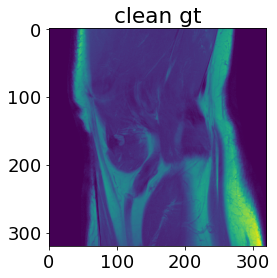

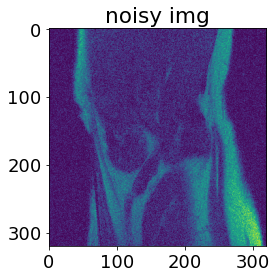

origin PSNR is:21.057153247987127


In [2]:
name = 'MRI Guided Decoder with λ = 1 & υ = 1'
log_path_prefix = '../log/MRI Result'
img_path = '../data/MRI/test_turth0000.npy'
noisy_path = '../data/MRI/test_0.1sigma0000.npy'
save_img_path_prefix = '../output'

log_dir = os.path.join(log_path_prefix, name)
save_img_dir = os.path.join(save_img_path_prefix, name)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
if not os.path.exists(save_img_dir):
    os.makedirs(save_img_dir)
writer = SummaryWriter(log_dir)
### Import data and show
img_pil = abs(np.load(img_path))
img_np = img_pil.reshape(1, img_pil.shape[0], img_pil.shape[1])
# img_pil = np_to_pil(img_np)

dtype_range = {bool: (False, True),
               np.bool_: (False, True),
               np.bool8: (False, True),
               float: (-1, 1),
               np.float_: (-1, 1),
               np.float16: (-1, 1),
               np.float32: (-1, 1),
               np.float64: (-1, 1)}
dmin, dmax = dtype_range[img_np.dtype.type]
print(dmin, dmax)

# noise level
img_noisy_pil = abs(np.load(noisy_path))
img_noisy_np  = img_noisy_pil.reshape(1, img_noisy_pil.shape[0], img_noisy_pil.shape[1])

plt.imshow(img_pil)
plt.title('clean gt')
plt.show()
plt.title('noisy img')
plt.imshow(img_noisy_pil)
plt.show()

print("origin PSNR is:{}".format(compare_psnr(img_pil, img_noisy_pil)))

### Guided-DIP

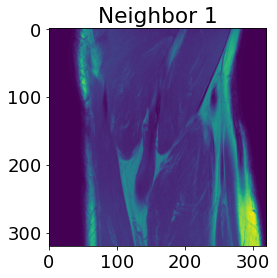

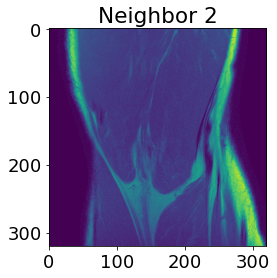

Neighbor 1 PSNR is 16.37080028953077
Neighbor 2 PSNR is 16.216434664799852


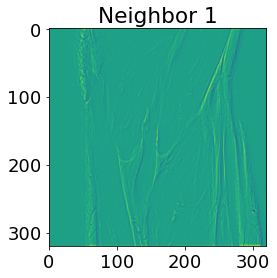

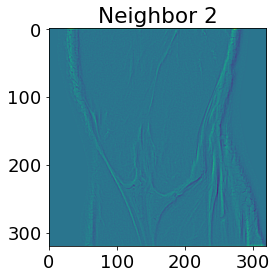

In [3]:
Neighbor = []
neighbor_1_path = '../data/MRI/groundturth1999.npy'
neighbor_2_path = '../data/MRI/groundturth2000.npy'
gakernel = gaussian_kernel(size=5, channels=1, sigma=5, dtype=torch.float).cuda()

neighbor_1_pil = abs(np.load(neighbor_1_path))
neighbor_1_np = neighbor_1_pil.reshape(1, neighbor_1_pil.shape[0], neighbor_1_pil.shape[1])
Neighbor.append(create_laplacian_pyramid(np_to_torch(neighbor_1_np).cuda(),gakernel,1)[0])

neighbor_2_pil = abs(np.load(neighbor_2_path))
neighbor_2_np = neighbor_2_pil.reshape(1, neighbor_2_pil.shape[0], neighbor_2_pil.shape[1])
Neighbor.append(create_laplacian_pyramid(np_to_torch(neighbor_2_np).cuda(),gakernel,1)[0])
plt.imshow(neighbor_1_pil)
plt.title('Neighbor 1')
plt.show()
plt.title('Neighbor 2')
plt.imshow(neighbor_2_pil)
plt.show()

print("Neighbor 1 PSNR is {}".format(compare_psnr(img_np, neighbor_1_np)))
print("Neighbor 2 PSNR is {}".format(compare_psnr(img_np, neighbor_2_np)))

plt.imshow(Neighbor[0].cpu().numpy()[0][0])
plt.title('Neighbor 1')
plt.show()
plt.title('Neighbor 2')
plt.imshow(Neighbor[1].cpu().numpy()[0][0])
plt.show()

### Net Prepare

In [4]:
"""y_input_torch = torch.from_numpy(img_np).type(dtype)
y_input_torch = torch.abs(y_input_torch.unsqueeze(0)).to(device)"""

INPUT = 'fourier'  # 'meshgrid', 'noise', 'fourier'
var = 1
input_depth = 32
net_input = get_noise(input_depth, INPUT, (img_pil.shape[0] // 32, img_pil.shape[1] // 32), var=var).type(dtype).detach()

z_list =[]
for j in range(2):
    z_random = get_noise(input_depth, INPUT, (img_pil.shape[0]//32, img_pil.shape[1]//32),var=var).type(dtype).detach().requires_grad_(True)
    z_list.append(z_random)


#network parameters
ln_lambda = 1.4  #the lambda in Lipschitz normalization, which is used to control spectral bias
upsample_mode = 'bilinear'  #['deconv', 'nearest', 'bilinear', 'gaussian'], where 'gaussian' denotes our Gaussian upsampling.
pad = 'reflection'
#decoder is the used network architecture in the paper
net = decoder(num_input_channels=input_depth, num_output_channels=1, ln_lambda=ln_lambda,
              upsample_mode=upsample_mode, pad=pad, need_sigmoid=True, need_bias=True).type(dtype)

#optimization parameters
OPTIMIZER = 'adam'
num_iter = 10000
LR = 0.001
reg_noise_std = 0  #1./30, injecting noise in the input.
show_every = 100

#automatic stopping
ratio_list = np.zeros(num_iter)
ratio_iter = 100  #the n in Eq. (8)
ratio_epsilon = 0.01  #the ratio difference threshold
auto_stop = False

# Loss
mse = torch.nn.MSELoss().type(dtype)
img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
last_net = None
psrn_noisy_last = 0

i = 0
ratio_part1 = 1
ratio_part2 = 1
ignite_epoch = 100
mean_out = 0
sum_out = 0

def closure():
    global i, out, psrn_noisy_last, last_net, net_input, mean_out, sum_out

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)

    out = net(net_input)

    loss_x = torch.tensor(0).float().cuda()
    loss_z = torch.tensor(0).float().cuda()
    for z_i,image in zip(z_list,Neighbor):
        z_i = z_i.cuda()
        z_i_out = net(z_i)
        z_i_out = z_i_out.cuda()
        z_i_out = create_laplacian_pyramid(z_i_out,gakernel,1)[0]
        image_change = image.cuda()
        loss_x += mse(z_i_out.type(dtype),torch.abs(image_change))# second term of the equation ||x_c-G(z_i)||
        loss_z += mse(z_i ,net_input)  # which is the third term of the equation || z_i -z||"""
    loss1 = mse(out, img_noisy_torch)
    loss2 = loss_x*ratio_part1
    loss3 = loss_z*ratio_part2
    total_loss = loss1 + loss2 + loss3

    total_loss.backward()

    """if i > ignite_epoch:
        sum_out += out.detach().cpu().numpy()[0]
        mean_out = sum_out/(i-ignite_epoch)
        out = np_to_torch(mean_out)"""



    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0])
    psrn_gt = compare_psnr(img_np, out.detach().cpu().numpy()[0])

    pre_img = out.detach().cpu().numpy()[0]
    pre_img = pre_img.transpose(1, 2, 0)
    noisy_img = img_noisy_np.transpose(1, 2, 0)

    #frequency-band correspondence metric
    avg_mask_it = get_circular_statastic(pre_img, noisy_img, size=0.2)

    #automatic stopping
    # blur_it = PerceptualBlurMetric(pre_img)  #the blurriness of the output image
    #sharp_it = MLVSharpnessMeasure(pre_img)  #the sharpness of the output image
    #ratio_it = blur_it / sharp_it  #the ratio

    # print ('Iteration: %05d, Loss: %f, PSRN_gt: %f' % (i, total_loss.item(), psrn_gt))
    vfi_gt = vifp_mscale(img_np, out.detach().cpu().numpy()[0])
    writer.add_scalar('PSNR_GT', psrn_gt, i)
    writer.add_scalar('VIF', vfi_gt, i)
    writer.add_scalar('Loss', total_loss.item(), i)
    writer.add_scalar('Loss/Loss1', loss1, i)
    writer.add_scalar('Loss/Loss2', loss2, i)
    writer.add_scalar('Loss/loss3', loss3, i)
    writer.add_scalar('Mask/brand 0', avg_mask_it[0], i)
    writer.add_scalar('Mask/brand 1', avg_mask_it[1], i)
    writer.add_scalar('Mask/brand 2', avg_mask_it[2], i)
    writer.add_scalar('Mask/brand 3', avg_mask_it[3], i)
    writer.add_scalar('Mask/brand 4', avg_mask_it[4], i)

    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5:
            print('Falling back to previous checkpoint, PSNR is {}'.format(psrn_noisy))

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss * 0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy

    i += 1

    return total_loss

### Train

In [5]:
print('Starting optimization with ADAM')
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
optimizer2 = torch.optim.Adam([z_list[0],z_list[1]],lr=LR)
for j in range(num_iter):
    optimizer.zero_grad()
    optimizer2.zero_grad()
    closure()
    optimizer.step()
    optimizer2.step()
# optimize(OPTIMIZER, net.parameters(), closure, LR, num_iter)

Starting optimization with ADAM


### Output Saved

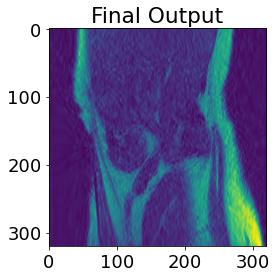

In [7]:
torch.save(net, os.path.join(save_img_dir,  'model.pth'))
if reg_noise_std > 0:
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)

out = net(net_input)
output_img_np = torch_to_np(out)

output_img_pil = np_to_pil(output_img_np)
plt.imshow(output_img_pil)
plt.title('Final Output')
plt.show()
writer.add_image('Final Output', output_img_np)

tensor([[[[-0.9402, -0.9646, -0.8083,  ..., -0.7678, -0.2408, -0.6490],
          [-0.4232, -0.5475, -0.5081,  ..., -0.3687, -0.2147, -0.6549],
          [-0.9643, -0.8930, -0.5885,  ..., -0.8489, -0.0283, -0.9790],
          ...,
          [ 0.9793, -0.1247,  0.1150,  ..., -0.9786,  0.6939,  0.0806],
          [-0.0311,  0.9920,  0.8406,  ...,  0.6297, -0.4799, -0.9051],
          [-0.9713, -0.3938,  0.9499,  ...,  0.9798, -0.8801,  0.8825]],

         [[ 0.8305, -0.8288,  0.3734,  ..., -0.2951, -0.4469,  0.0383],
          [-0.6141, -0.3211,  0.4465,  ..., -0.9893, -0.9830, -0.0102],
          [-0.9760, -0.8695, -0.3111,  ..., -0.1072, -0.6621, -0.6708],
          ...,
          [-0.8482, -0.0922,  0.1563,  ...,  0.5343, -0.7140, -0.9412],
          [-0.8752, -0.8475,  0.9640,  ...,  0.7826, -0.9164, -0.6951],
          [-0.8856,  0.3550, -0.9853,  ..., -0.4571, -0.3919, -0.7910]],

         [[ 0.9247, -0.9307,  0.9134,  ..., -0.2385, -0.5161, -0.9148],
          [ 0.2208,  0.5291,  